In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score # feature importance categoric variables
from sklearn.feature_extraction import DictVectorizer # One hot encoding
from IPython.display import display
from sklearn.linear_model import LogisticRegression # logistic regression # Ridge is regularised logistic regression
from sklearn.impute import SimpleImputer # for imputing null values, using in 3.10 logistic regression

In [2]:
#import csv
#use full location including raw.githubusercontent
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv", sep = ",")
#print(df.head())
print(df.head().T) # transposes, making rows columns


                                 0             1               2  \
customerID              7590-VHVEG    5575-GNVDE      3668-QPYBK   
gender                      Female          Male            Male   
SeniorCitizen                    0             0               0   
Partner                        Yes            No              No   
Dependents                      No            No              No   
tenure                           1            34               2   
PhoneService                    No           Yes             Yes   
MultipleLines     No phone service            No              No   
InternetService                DSL           DSL             DSL   
OnlineSecurity                  No           Yes             Yes   
OnlineBackup                   Yes            No             Yes   
DeviceProtection                No           Yes              No   
TechSupport                     No            No              No   
StreamingTV                     No            No

In [3]:
# cleaning
#df.dtypes
df.columns = df.columns.str.lower().str.replace(' ', '_') #making columns lower case and replacing space with underscore
#identify string columns
string_cols = df.select_dtypes(include='object').columns.tolist()
categorical_columns = string_cols
#print(string_cols)

for c in categorical_columns:
        df[c] = df[c].str.lower().str.replace(' ', '_')

# checking for null values in columns
# df[tc.isnull()][['customerid', 'totalcharges']]
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges.fillna(0) # should we set null values to 0?

# change yes no churn values to 0 and 1
df.churn = (df.churn == 'yes').astype(int)
print(df.head().T)


                                 0             1               2  \
customerid              7590-vhveg    5575-gnvde      3668-qpybk   
gender                      female          male            male   
seniorcitizen                    0             0               0   
partner                        yes            no              no   
dependents                      no            no              no   
tenure                           1            34               2   
phoneservice                    no           yes             yes   
multiplelines     no_phone_service            no              no   
internetservice                dsl           dsl             dsl   
onlinesecurity                  no           yes             yes   
onlinebackup                   yes            no             yes   
deviceprotection                no           yes              no   
techsupport                     no            no              no   
streamingtv                     no            no

In [4]:
#set up the validatin framework using scikit learn
#train_test_split only breaks the data into training and testing
# need extra step into train test validation
df_train_full, df_test = train_test_split(df, test_size = 0.2, random_state = 1) 
df_train, df_val = train_test_split(df_train_full, test_size = 0.25, random_state = 11)

#reset indexes for prettiness
df_train = df_train.reset_index(drop = True)
df_val = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']
# check split amounts
len(df_train), len(df_test), len(df_val), len(df_train) + len(df_test) + len(df_val), len(df)

(4225, 1409, 4225, 9859, 7043)

In [5]:
# exploring the data
#df_train_full.isnull().sum()
df_train_full.churn.value_counts()
global_mean = df_train_full.churn.mean()
round(global_mean, 2)

np.float64(0.27)

In [6]:
# list of string columns
#categorical = pd.concat([df_train, df_val]).select_dtypes(include='object').columns.tolist()
#numerical = pd.concat([df_train, df_val]).select_dtypes(include=['int64', 'float']).columns.tolist()

#manual to align with course and use columns that make sense
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

print (categorical)
print (numerical)

['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
['tenure', 'monthlycharges', 'totalcharges']


In [7]:
# profile string datasets
#results = []
#for col in categorical:
#    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
#    df_group['diff'] = df_group['mean'] - global_mean
#    df_group['risk'] = df_group['mean'] / global_mean
#    df_group['variable'] = col
#    df_group = df_group.reset_index().rename(columns= {col:'category'})
#    results.append(df_group)
#    #display (df_group) #this shows individual records

 #combine all into one dataframe
#df_summary = pd.concat(results, ignore_index = True)
#df_summary[['variable', 'category', 'mean', 'diff', 'risk']]


for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


In [8]:
# churn rate
# percent of churn = 1
global_churn_rate = df_train_full.churn.mean()
# this also works
df_train_full.churn.value_counts(normalize = True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [9]:
# unique values in columns
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [10]:
#feature importance

female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print ('gender==femaile:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print ('gender == male:', round(male_mean, 3))

print ('female mean / global:', round(female_mean / global_mean, 3))
print ('male mean / global:', round(male_mean / global_mean, 3))

gender==femaile: 0.277
gender == male: 0.263
female mean / global: 1.025
male mean / global: 0.975


In [11]:
df_group = df_train_full.groupby(by = 'gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean # churn rate within group vs global churn rate. Do they over or under index?
df_group['risk'] = df_group['mean']/ global_mean 
df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [12]:
global_mean

np.float64(0.26996805111821087)

In [13]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


In [14]:
def calculate_mi(series):
    return mutual_info_score(series, sf_train_full.churn)

    df_mi = df_train_full[categorical].apply(calcualte_mi)
    df_mi = df_mi.sort_values(ascending=False).to_frame(name='M1')

    display(df_mi.head())
    display(df_mi.tail())

#numeric correlations
df_train_full[numerical].corrwith(df_train_full.churn).to_frame('correlation')
# churn results for numeric
df_train_full.groupby(by='churn')[numerical].mean()

,tenure,monthlycharges,totalcharges
churn,,,
0,37.531972,61.176477,2552.987320
1,18.070348,74.521203,1545.689415


In [15]:
### Feature importance of categorical variables

In [16]:
mutual_info_score(df_train_full.churn, df_train_full.contract)

0.0983203874041556

In [17]:
mutual_info_score(df_train_full.gender, df_train_full.churn)

0.0001174846211139946

In [18]:
mutual_info_score(df_train_full.contract, df_train_full.churn)

0.0983203874041556

In [19]:
mutual_info_score(df_train_full.partner, df_train_full.churn)

0.009967689095399745

In [20]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_train_full.churn)

In [21]:
mi = df_train_full[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

In [22]:
### Feature importance of numeric variables
## Pearsons correlation
## way to measure relationship between two variables

In [23]:
df_train_full.tenure.max()

np.int64(72)

In [24]:
#df_train_full[numerical].corrwith(df_train_full.churn).abs()
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.197416
dtype: float64

In [25]:
df_train_full[df_train_full.tenure <=2].churn.mean()

np.float64(0.5953420669577875)

In [26]:
df_train_full[(df_train_full.tenure > 2) & (df_train_full.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [27]:
df_train_full[df_train_full.tenure > 12].churn.mean()

np.float64(0.17634908339788277)

In [28]:
df_train_full[df_train_full.monthlycharges <= 20].churn.mean()

np.float64(0.08795411089866156)

In [29]:
df_train_full[df_train_full.monthlycharges > 50].churn.mean()

np.float64(0.32499341585462205)

In [30]:
##
## One hot encoding
## How can we encode categorical variables for the model?
## Creates a vector with fields on the top and positive values are 1 in the data
## Hot means those values are activated, cold values would be 0
## If numeric variables sneak into the dataset they are left unchanged, not turned into 0/1
## We did this in the car section??

In [31]:
# orient = records we turn each record into a dictionary
dicts = df_train[['gender', 'contract']].iloc[:100].to_dict(orient = 'records')
dv = DictVectorizer( sparse = False)
dv.fit(dicts)
dv.transform(dicts)

array([[0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0.

In [32]:
## old version get_feature_names
# shows you the columns in the dv array above
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'gender=female', 'gender=male'], dtype=object)

In [33]:
dv = DictVectorizer(sparse= False)  # sparse does something vancy with 0s

train_dict = df_train[categorical + numerical].to_dict(orient='records')
x_train = dv.fit_transform(train_dict) #same as doing the fit then the transformation

val_dict = df_val[categorical + numerical].to_dict(orient = 'records')
x_val = dv.transform(val_dict) # no need to fit on the validation dataset

In [34]:
dv.transform(train_dict[:5])[0]
list(dv.transform(train_dict[:5])[0])

[np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(105.2),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(58.0),
 np.float64(6225.4)]

In [35]:
################
## 3.9 Logistinc regression ##
## Binary - yes or no, only 0 and 1 examples
## probability of xi belonging to positive class
###############

In [36]:
def sigmoid(z):
    return 1/ (1+ np.exp(-z)) # np.exp means exponent

In [37]:
# a range of values between 5 and -5
z = np.linspace(-5, 5, 51)

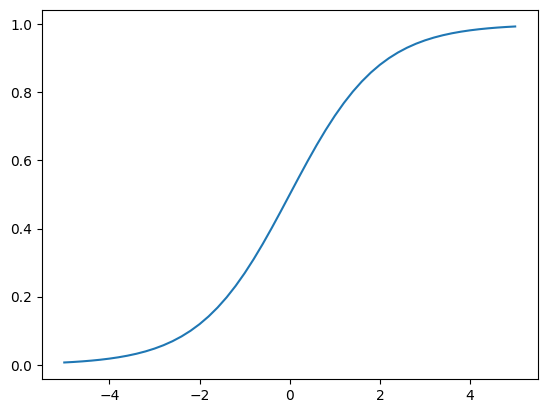

In [38]:
# this function is defined above in def sigmoid(z)
# sigmoid(z) # shows numeric range. always between 0 and 1
plt.plot(z, sigmoid(z))

In [39]:
# linear, logistic below
def linear_regression(xi):
    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]

    return result

In [40]:
# logistic, linear above
# logistic is yes or no
def logistic_regression(xi):
    score = w0

    for j in range(len(w)):
        score = score + xi[j] * w[j]

    result = sigmoid(score)
    
    return result

In [41]:
## 3.10 training logistic regression model
imputer = SimpleImputer(strategy='mean') # replace null values with mean. for categorical variables put 'most frequent'
x_train = imputer.fit_transform(x_train)
x_val = imputer.fit_transform(x_val)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
# solver lbfgs is the default solver in new versions of sklearn, older versions need to specify
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [42]:
model.intercept_[0]

np.float64(-0.14946668965214505)

In [43]:
model.coef_[0].round(3) # this provides w, the weights

array([ 0.678, -0.006, -0.813, -0.012, -0.129,  0.069, -0.124, -0.086,
       -0.033, -0.108, -0.365,  0.348, -0.124,  0.   , -0.184,  0.08 ,
       -0.037,  0.106, -0.124, -0.123,  0.238, -0.124, -0.255, -0.225,
        0.084, -0.082, -0.059, -0.055, -0.122,  0.2  , -0.164,  0.08 ,
       -0.221,  0.227, -0.095, -0.124,  0.078, -0.092, -0.124,  0.075,
        0.182, -0.124, -0.198, -0.062,  0.   ])

In [44]:
model.predict(x_train) # hard predictions, already have the label, don't know the probability

array([0, 1, 0, ..., 0, 0, 0], shape=(4225,))

In [45]:
model.predict_proba(x_train) # col 1 is prob of negative, column 2 is probability of 1

array([[0.77546566, 0.22453434],
       [0.2885587 , 0.7114413 ],
       [0.99893035, 0.00106965],
       ...,
       [0.89008864, 0.10991136],
       [0.89106147, 0.10893853],
       [0.88395017, 0.11604983]], shape=(4225, 2))

In [46]:
y_pred = model.predict_proba(x_val)[:, 1] # soft predictions. probability, not strict answer
y_pred # look at these numbers to determine threshold

array([0.22453434, 0.7114413 , 0.00106965, ..., 0.10991136, 0.10893853,
       0.11604983], shape=(4225,))

In [47]:
churn_decision = (y_pred >= 0.5)

In [48]:
# select all rows for churn_decision = true
df_val[churn_decision].customerid

1       6127-isgtu
3       8485-gjcdn
16      4919-ikaty
26      1730-zmame
27      6689-tczhq
           ...    
4210    4716-hhkqh
4211    6900-pxrms
4213    1112-cunao
4218    5449-fibxj
4221    4342-hentk
Name: customerid, Length: 982, dtype: object

In [49]:
## Test model, similar to RMSE in logistic we use accuracy
churn_decision.astype(int)
churn_decision = (y_pred >= 0.5)

In [50]:
(y_val == churn_decision).mean() # this is a shortcut of doing all the df_pred exercise below

np.float64(0.8033136094674557)

In [51]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred #soft predictions
df_pred['prediction'] = churn_decision.astype(int) # hard prediction
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.224534,0,0,True
1,0.711441,1,1,True
2,0.001070,0,0,True
3,0.671651,1,1,True
4,0.417561,0,1,False
...,...,...,...,...
4220,0.040842,0,0,True
4221,0.768680,1,1,True
4222,0.109911,0,1,False
4223,0.108939,0,0,True


In [52]:
df_pred

,probability,prediction,actual,correct
0,0.224534,0,0,True
1,0.711441,1,1,True
2,0.001070,0,0,True
3,0.671651,1,1,True
4,0.417561,0,1,False
...,...,...,...,...
4220,0.040842,0,0,True
4221,0.768680,1,1,True
4222,0.109911,0,1,False
4223,0.108939,0,0,True


In [53]:
df_pred.correct.mean()

np.float64(0.8033136094674557)

In [54]:
churn_decision.astype(int)

array([0, 1, 0, ..., 0, 0, 0], shape=(4225,))

In [55]:
## 3.11 Model Interpretation ##

In [77]:
model.coef_[0].round(3)

array([ 0.678, -0.006, -0.813, -0.012, -0.129,  0.069, -0.124, -0.086,
       -0.033, -0.108, -0.365,  0.348, -0.124,  0.   , -0.184,  0.08 ,
       -0.037,  0.106, -0.124, -0.123,  0.238, -0.124, -0.255, -0.225,
        0.084, -0.082, -0.059, -0.055, -0.122,  0.2  , -0.164,  0.08 ,
       -0.221,  0.227, -0.095, -0.124,  0.078, -0.092, -0.124,  0.075,
        0.182, -0.124, -0.198, -0.062,  0.   ])

In [56]:
# example to see what zip does
# joins 1 to a, 2 to b etc
a = [1,2,3,4]
b = 'abcd'

In [78]:
dict(zip(a, b)) # dictionary list a becomes a variable b becomes values
#list(zip(a, b))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

In [79]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.678),
 'contract=one_year': np.float64(-0.006),
 'contract=two_year': np.float64(-0.813),
 'dependents=no': np.float64(-0.012),
 'dependents=yes': np.float64(-0.129),
 'deviceprotection=no': np.float64(0.069),
 'deviceprotection=no_internet_service': np.float64(-0.124),
 'deviceprotection=yes': np.float64(-0.086),
 'gender=female': np.float64(-0.033),
 'gender=male': np.float64(-0.108),
 'internetservice=dsl': np.float64(-0.365),
 'internetservice=fiber_optic': np.float64(0.348),
 'internetservice=no': np.float64(-0.124),
 'monthlycharges': np.float64(0.0),
 'multiplelines=no': np.float64(-0.184),
 'multiplelines=no_phone_service': np.float64(0.08),
 'multiplelines=yes': np.float64(-0.037),
 'onlinebackup=no': np.float64(0.106),
 'onlinebackup=no_internet_service': np.float64(-0.124),
 'onlinebackup=yes': np.float64(-0.123),
 'onlinesecurity=no': np.float64(0.238),
 'onlinesecurity=no_internet_service': np.float64(-0.124),
 'onlinesecurity=yes':

In [81]:
small = ['contract', 'tenure', 'monthlycharges']

In [82]:
# top 10 records
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'one_year', 'tenure': 58, 'monthlycharges': 105.2},
 {'contract': 'month-to-month', 'tenure': 16, 'monthlycharges': 84.95},
 {'contract': 'two_year', 'tenure': 71, 'monthlycharges': 19.45},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 69.05},
 {'contract': 'month-to-month', 'tenure': 47, 'monthlycharges': 85.3},
 {'contract': 'one_year', 'tenure': 62, 'monthlycharges': 54.75},
 {'contract': 'one_year', 'tenure': 36, 'monthlycharges': 54.45},
 {'contract': 'one_year', 'tenure': 18, 'monthlycharges': 89.6},
 {'contract': 'one_year', 'tenure': 30, 'monthlycharges': 25.35},
 {'contract': 'month-to-month', 'tenure': 40, 'monthlycharges': 50.85}]

In [64]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [65]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [66]:
x_train_small = dv_small.transform(dicts_train_small)

In [83]:
model_small_a = LogisticRegression()
model_small.fit(x_train_small, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [69]:
model_small = LogisticRegression(solver='lbfgs',  max_iter=1000)
model_small.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [89]:
# bias?
# what we assume without knowing anything
# model_small.intercept_[0]

# this converts bias into a % probability
sigmoid(model_small.intercept_[0])

# add w values to the sigmoid to see how the probability changes
# 0.678 is the w value for customers on m2m, calculated below assuming 50 customers have m2m plan
sigmoid(model_small.intercept_[0] + 50* 0.678)

np.float64(0.9999999999999742)

In [85]:
# these are the weights, the w
# formula is bias (model_small.intercept) + records * weights
# eg. 50 customers for 1 month, 10 customers for 6m contract do bias + 50 x w for 1m customers + 10 x w for 6m customers
model_small.coef_[0]

array([ 1.05526523, -0.00787412, -1.04757129,  0.02872729, -0.03569855])

In [70]:
w0 = model_small.intercept_[0]
w0

np.float64(-0.14946668965214505)

In [72]:
w = model_small.coef_[0]
w.round(3)

array([ 0.678, -0.006, -0.813, -0.012, -0.129,  0.069, -0.124, -0.086,
       -0.033, -0.108, -0.365,  0.348, -0.124,  0.   , -0.184,  0.08 ,
       -0.037,  0.106, -0.124, -0.123,  0.238, -0.124, -0.255, -0.225,
        0.084, -0.082, -0.059, -0.055, -0.122,  0.2  , -0.164,  0.08 ,
       -0.221,  0.227, -0.095, -0.124,  0.078, -0.092, -0.124,  0.075,
        0.182, -0.124, -0.198, -0.062,  0.   ])

In [86]:
# weights
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': np.float64(0.678),
 'contract=one_year': np.float64(-0.006),
 'contract=two_year': np.float64(-0.813),
 'monthlycharges': np.float64(-0.012),
 'tenure': np.float64(-0.129)}

In [76]:
# underscore means take value from previous cell
# converts weight formula to a probability
sigmoid(_) 

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])